# PDE-FIND za Van der Polov oscilator

Vinko Dragušica, 2022.

Predstavljen je kod koji pomoću modula PDE-FIND iz danih podataka otkriva jednadžbu koja opisuje dinamiku Van der Polovog oscilatora za $\mu=2$.
$$
u_{tt} - \mu(1-x^2)u_t + u = 0
$$

In [1]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import sys; sys.path.append('../')
from PDE_FIND_CM import *

In [2]:
import pandas
df = pandas.read_csv('../Datasets/VanDerPol.csv', skiprows=1, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,3.0,2.99057,2.97361,2.955021,2.935976,2.916714,2.897278,2.877676,2.857905,2.837962,...,0.35676,0.7094,1.089274,1.443639,1.717251,1.890103,1.979597,2.014786,2.018807,2.005845


In [3]:
u = df.to_numpy()
x = [0]
t = np.linspace(0,50,500)
dt = t[1]-t[0]
#dx = x[1]-x[0]

Text(0, 0.5, 'u(t)')

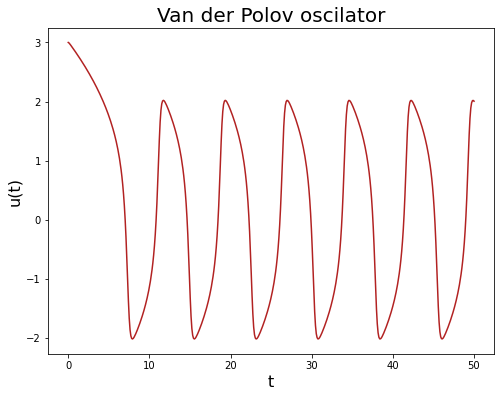

In [4]:
fig1 = plt.figure(figsize=(8,6))
plt.plot(t,u[0,:],color='firebrick')
plt.title('Van der Polov oscilator', fontsize = 20)
plt.xlabel('t', fontsize = 16)
plt.ylabel('u(t)', fontsize = 16)

## Konstruiramo $\Theta (U)$ i računamo $U_t$:

Konstruiramo funkcije koje će se nalaziti u $\Theta$. Također specificiramo njihove opise i na kraju pomoću build_Theta konstruiramo $\Theta$ koji ćemo koristiti kasnije. <br>
time_diff i space_diff izračunati su pomoću metode konačnih razlika (funkcija FiniteDiff()).

Ispisana je lista funkcija kandidata za PDJ. Svaka od ispisanih funkcija ekvivalentna je stupcu u $\Theta (U)$.

In [5]:
m = len(x)
n = len(t)

ut = np.zeros((m,n), dtype=np.complex64)
utt = np.zeros((m,n), dtype=np.complex64)

for i in range(m):
    ut[i,:] = FiniteDiff(u[i,:], dt, 1)
    utt[i,:] = FiniteDiff(u[i,:], dt,2) # koristi se kasnije kod funkcije TrainSTRidge

ut = np.reshape(ut, (n*m,1), order='F')
utt = np.reshape(utt, (n*m,1), order='F')

X_ders = np.hstack([np.ones((n*m,1)),ut])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F')])
derivatives_description = ['','u_{t}']

X, descr = build_Theta(X_data, X_ders, derivatives_description, P=2, data_description = ['u'])
descr

['', 'u_{t}', 'u', 'u^2', 'uu_{t}', 'u^2u_{t}']

## Računamo $\xi$:

TrainSTRidge dijeli podatke na dio za trening (80% ukupnih podataka) i dio za validaciju (20% ukupnih podataka). Algoritam traži optimalnu vrijednost za varijablu tol (tolerancija ispod koje zanemarujemo varijablu) i odabire toleranciju provjerom na validacijskom skupu, uključujući i $\ell^0$ penalizaciju za $\xi$ u funkciji gubitka.

In [6]:
# Solve with STRidge
w = TrainSTRidge(X,utt,10**-5,0.1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, descr)

PDJ dobivena pomoću STRidge:
u_tt = (1.941602 +0.000000i)u_{t}
    + (-0.972596 +0.000000i)u
    + (-1.942509 +0.000000i)u^2u_{t}
   


In [7]:
err = abs(np.array([(2 -  1.941602)/2*100,(1 - 0.972596)*100,(2 - 1.942509)/2*100]))
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:\n")
print("Srednja greška parametara:", np.mean(err), '%')
print("Standardna devijacija srednje greške parametara:", np.std(err), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:

Srednja greška parametara: 2.8449499999999976 %
Standardna devijacija srednje greške parametara: 0.07621103375933576 %


Jednadžba $u_{tt} = 2 u_t - u - 2 x^2 u_t$ je dosta dobro rekonstruirana, ali tek nakon što je broj točaka u danom vremenskom intervalu $[0,50]$ povećan na N=500.